In [ ]:
from pulp import LpVariable, LpProblem, LpMinimize, lpSum, LpStatus, LpStatusOptimal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
config = {
    'gamma': 105,
    'min_freq': 25,
    'max_freq': 35,
    'fleet_limit': 65,
    'train_cost_per_hour': 100,  # Not used in Option 2 but kept for consistency
    'risk_weights': {'SUDP': 1.5, 'MUPAA': 1.3, 'MUO': 1.2, 'MUATC': 1.2, 'PUMST': 1.1},
    'soft_cap_threshold': 250,
    'soft_cap_value': 30,
    'hours': list(range(6, 24))
}


In [ ]:
def load_and_prepare_data(filepath, config):
    # STEP 1: Load and convert date+time to full datetime
    df = pd.read_excel(filepath)
    df['Timestamp'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

    # STEP 2: Filter only TTC Line 1 (Yonge-University)
    df = df[df['Line'] == 'YU']

    # STEP 3: Normalize and clean the 'Code' column
    df['Code'] = df['Code'].astype(str).str.strip().str.upper()

    # STEP 4: Filter based on real TTC operating hours
    # - Weekdays & Saturdays: service from 6:00 AM
    # - Sundays: service from 8:00 AM
    df['Weekday'] = df['Timestamp'].dt.weekday  # Monday = 0, Sunday = 6
    df['Hour'] = df['Timestamp'].dt.hour

    condition = (
        ((df['Weekday'] <= 5) & (df['Hour'] >= 6)) |    # Weekdays & Saturdays: from 6 AM
        ((df['Weekday'] == 6) & (df['Hour'] >= 8))      # Sundays: from 8 AM
    ) & (df['Hour'] <= 23)  # Cutoff at 11 PM for modeling

    df = df[condition].copy()  # <-- 🆕 Step: Prune based on TTC operating hours

    # STEP 5: Drop invalid or missing entries
    df = df.dropna(subset=['Date', 'Time', 'Min Delay', 'Code'])
    df = df[df['Min Delay'] > 0]

    # STEP 6: Clip outlier delays above 45 minutes
    df['Min Delay'] = df['Min Delay'].clip(upper=45)

    # STEP 7: Filter to only codes with defined risk weights
    df = df[df['Code'].isin(config['risk_weights'])].copy()

    # STEP 8: Map risk scores to codes
    df['Score'] = df['Code'].map(config['risk_weights'])

    # STEP 9: Group by hour and sum risk scores
    hourly_risk = df.groupby('Hour')['Score'].sum().to_dict()

    # STEP 10: Construct delay_pressure dictionary for optimization
    delay_pressure = {t: hourly_risk.get(t, 0) for t in config['hours']}

    return delay_pressure


In [ ]:
def load_and_prepare_data(filepath, config):
    df = pd.read_excel(filepath)
    df['Timestamp'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
    df = df[df['Line'] == 'YU']
    df['Code'] = df['Code'].astype(str).str.strip().str.upper()
    df['Hour'] = df['Timestamp'].dt.hour

    df_risk = df[df['Code'].isin(config['risk_weights'])].copy()
    df_risk['Score'] = df_risk['Code'].map(config['risk_weights'])

    hourly_risk = df_risk.groupby('Hour')['Score'].sum().to_dict()
    delay_pressure = {t: hourly_risk.get(t, 0) for t in config['hours']}
    return delay_pressure

# Load using your file path
delay_pressure = load_and_prepare_data('/content/drive/MyDrive/ttc-subway-delay-data-2024_Line_1_Only.xlsx', config)


In [ ]:
def build_option2_model(delay_pressure, config):
    f = LpVariable.dicts("freq", config['hours'], lowBound=config['min_freq'], upBound=config['max_freq'], cat='Continuous')
    prob = LpProblem("TTC_Option2_SoftCap", LpMinimize)

    # Objective: Minimize weighted deviation from max frequency
    prob += lpSum([delay_pressure[t] * (config['max_freq'] - f[t]) for t in config['hours']])

    # Add soft cap constraint for low-risk hours
    for t in config['hours']:
        if delay_pressure[t] < config['soft_cap_threshold']:
            prob += f[t] <= config['soft_cap_value'], f"SoftCap_{t}"

    # Add fleet constraint
    prob += lpSum([f[t] for t in config['hours']]) <= config['fleet_limit'] * len(config['hours']), "FleetLimit"

    return prob, f


In [ ]:
def solve_and_display(prob, f, delay_pressure, config):
    prob.solve()
    print(f"Status: {LpStatus[prob.status]}")
    results = []
    if prob.status == LpStatusOptimal:
        for t in config['hours']:
            freq_val = f[t].varValue if f[t].varValue else config['min_freq']
            delay_val = config['gamma'] / freq_val if freq_val > 0 else float('inf')
            results.append((t, freq_val, delay_val, delay_pressure[t]))
            print(f"{t:02d} | {freq_val:.1f} tph | {delay_val:.2f} min delay | Risk: {delay_pressure[t]}")
        print(f"Objective Value: {prob.objective.value():.2f}")
    else:
        print("No optimal solution found.")
    return results


In [ ]:
def plot_frequency_vs_risk(results):
    df = pd.DataFrame(results, columns=['Hour', 'Frequency', 'Delay', 'Risk'])

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(df['Hour'], df['Frequency'], 'o-', label='Frequency (tph)', color='blue')
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Frequency (tph)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(df['Hour'], df['Risk'], 'x--', label='Risk Pressure', color='red')
    ax2.set_ylabel('Risk Pressure', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title('Option 2: Frequency vs Risk (per day)') # Modified title
    fig.tight_layout()
    plt.grid(True)
    plt.show()

Status: Optimal
06 | 30.0 tph | 3.50 min delay | Risk: 176.3
07 | 30.0 tph | 3.50 min delay | Risk: 230.4
08 | 35.0 tph | 3.00 min delay | Risk: 293.6
09 | 30.0 tph | 3.50 min delay | Risk: 234.8
10 | 30.0 tph | 3.50 min delay | Risk: 226.0
11 | 35.0 tph | 3.00 min delay | Risk: 251.4
12 | 35.0 tph | 3.00 min delay | Risk: 299.1
13 | 35.0 tph | 3.00 min delay | Risk: 285.2
14 | 35.0 tph | 3.00 min delay | Risk: 304.4
15 | 35.0 tph | 3.00 min delay | Risk: 287.1
16 | 35.0 tph | 3.00 min delay | Risk: 358.7
17 | 35.0 tph | 3.00 min delay | Risk: 393.6
18 | 35.0 tph | 3.00 min delay | Risk: 334.5
19 | 35.0 tph | 3.00 min delay | Risk: 306.5
20 | 35.0 tph | 3.00 min delay | Risk: 272.2
21 | 30.0 tph | 3.50 min delay | Risk: 223.9
22 | 35.0 tph | 3.00 min delay | Risk: 272.0
23 | 35.0 tph | 3.00 min delay | Risk: 351.3
Objective Value: 5457.00


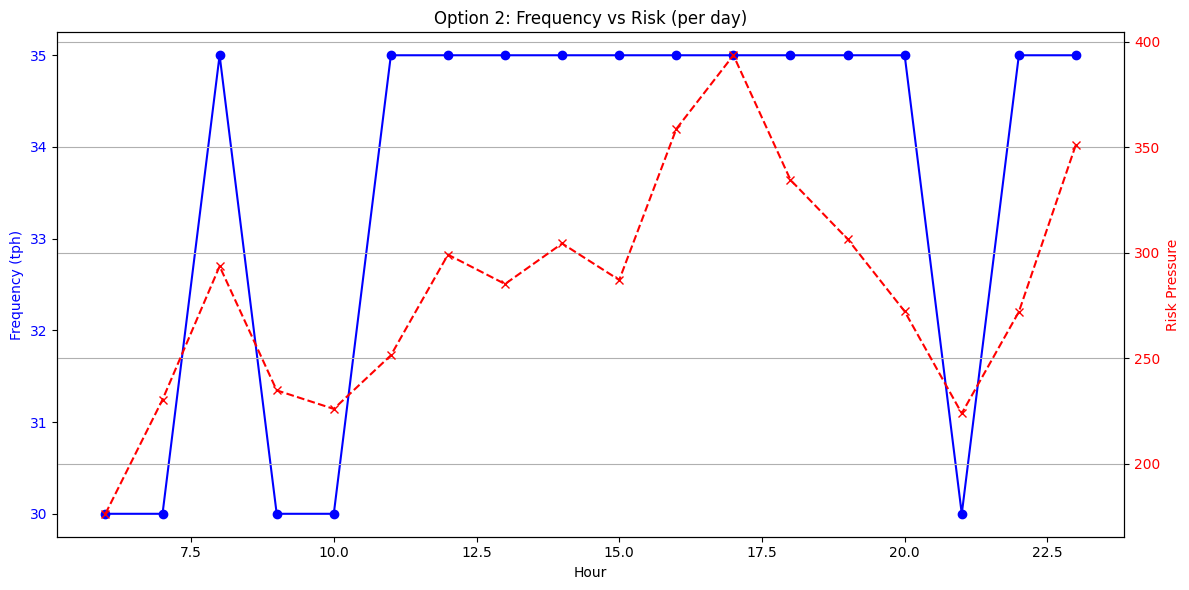

In [ ]:
# Build and solve Option 2 model
prob2, f2 = build_option2_model(delay_pressure, config)
results2 = solve_and_display(prob2, f2, delay_pressure, config)

# Plot
if results2:
    plot_frequency_vs_risk(results2)


In [ ]:
def build_option1_model(delay_pressure, config):
    f = LpVariable.dicts("freq", config['hours'], lowBound=config['min_freq'], upBound=config['max_freq'], cat='Continuous')
    prob = LpProblem("TTC_Option1_CostMin", LpMinimize)

    # Let's define Option 1 as minimizing total service hours (which is proportional to total frequency)
    prob += lpSum([f[t] for t in config['hours']]), "Minimize_Service_Hours"

    # Add fleet constraint
    prob += lpSum([f[t] for t in config['hours']]) <= config['fleet_limit'] * len(config['hours']), "FleetLimit"

    return prob, f

In [ ]:
def build_option3_model(delay_pressure, config):
    f = LpVariable.dicts("freq", config['hours'], lowBound=config['min_freq'], upBound=config['max_freq'], cat='Continuous')
    # Introduce a variable to represent the maximum delay
    max_delay = LpVariable("max_delay", lowBound=0)

    prob = LpProblem("TTC_Option3_MinMaxDelay", LpMinimize)

    # Objective: Minimize the maximum delay (by minimizing the negative of the minimum frequency)
    min_freq_var = LpVariable("min_overall_frequency", lowBound=config['min_freq'], upBound=config['max_freq'])
    prob += -min_freq_var, "Maximize_Minimum_Frequency" # Minimize the negative of the minimum frequency

    # Constraint: The frequency in each hour must be greater than or equal to min_freq_var
    for t in config['hours']:
        # Ensure constraint names are unique, using 'MinFreqConstraint_hour_{t}'
        prob += f[t] >= min_freq_var, f"MinFreqConstraint_hour_{t}"

    # Add fleet constraint
    prob += lpSum([f[t] for t in config['hours']]) <= config['fleet_limit'] * len(config['hours']), "FleetLimit_Option3" # Make fleet limit name unique for this option


    return prob, f

--- Solving Option 1 (Minimize Total Frequency) ---
Status: Optimal
06 | 25.0 tph | 4.20 min delay | Risk: 176.3
07 | 25.0 tph | 4.20 min delay | Risk: 230.4
08 | 25.0 tph | 4.20 min delay | Risk: 293.6
09 | 25.0 tph | 4.20 min delay | Risk: 234.8
10 | 25.0 tph | 4.20 min delay | Risk: 226.0
11 | 25.0 tph | 4.20 min delay | Risk: 251.4
12 | 25.0 tph | 4.20 min delay | Risk: 299.1
13 | 25.0 tph | 4.20 min delay | Risk: 285.2
14 | 25.0 tph | 4.20 min delay | Risk: 304.4
15 | 25.0 tph | 4.20 min delay | Risk: 287.1
16 | 25.0 tph | 4.20 min delay | Risk: 358.7
17 | 25.0 tph | 4.20 min delay | Risk: 393.6
18 | 25.0 tph | 4.20 min delay | Risk: 334.5
19 | 25.0 tph | 4.20 min delay | Risk: 306.5
20 | 25.0 tph | 4.20 min delay | Risk: 272.2
21 | 25.0 tph | 4.20 min delay | Risk: 223.9
22 | 25.0 tph | 4.20 min delay | Risk: 272.0
23 | 25.0 tph | 4.20 min delay | Risk: 351.3
Objective Value: 450.00


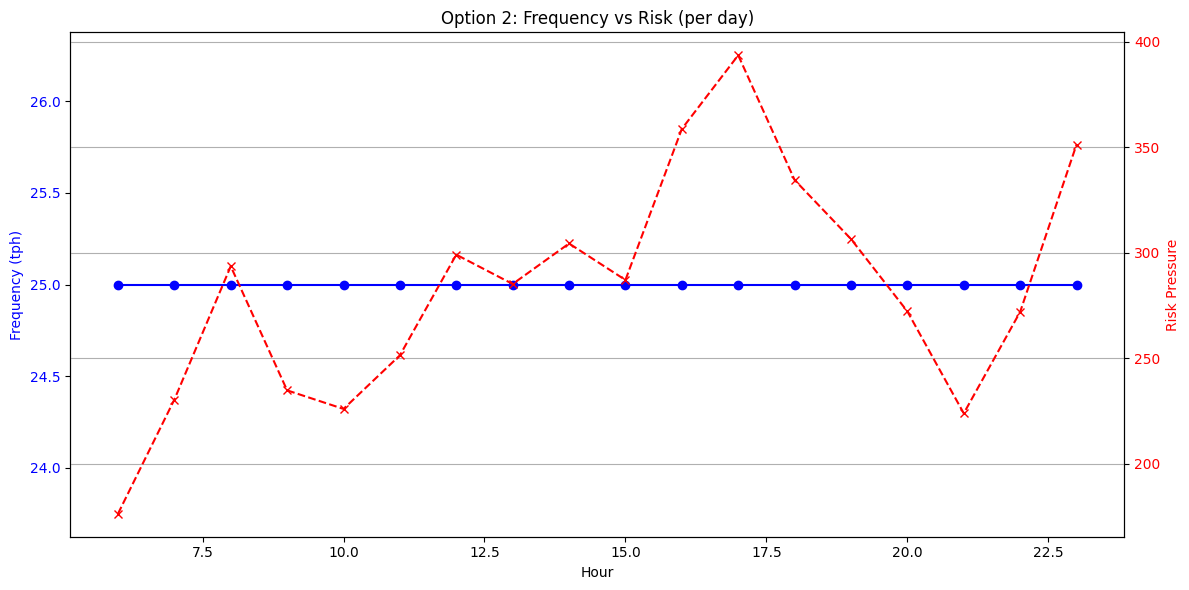


--- Solving Option 3 (Maximize Minimum Frequency) ---
Status: Optimal
06 | 35.0 tph | 3.00 min delay | Risk: 176.3
07 | 35.0 tph | 3.00 min delay | Risk: 230.4
08 | 35.0 tph | 3.00 min delay | Risk: 293.6
09 | 35.0 tph | 3.00 min delay | Risk: 234.8
10 | 35.0 tph | 3.00 min delay | Risk: 226.0
11 | 35.0 tph | 3.00 min delay | Risk: 251.4
12 | 35.0 tph | 3.00 min delay | Risk: 299.1
13 | 35.0 tph | 3.00 min delay | Risk: 285.2
14 | 35.0 tph | 3.00 min delay | Risk: 304.4
15 | 35.0 tph | 3.00 min delay | Risk: 287.1
16 | 35.0 tph | 3.00 min delay | Risk: 358.7
17 | 35.0 tph | 3.00 min delay | Risk: 393.6
18 | 35.0 tph | 3.00 min delay | Risk: 334.5
19 | 35.0 tph | 3.00 min delay | Risk: 306.5
20 | 35.0 tph | 3.00 min delay | Risk: 272.2
21 | 35.0 tph | 3.00 min delay | Risk: 223.9
22 | 35.0 tph | 3.00 min delay | Risk: 272.0
23 | 35.0 tph | 3.00 min delay | Risk: 351.3
Objective Value: -35.00


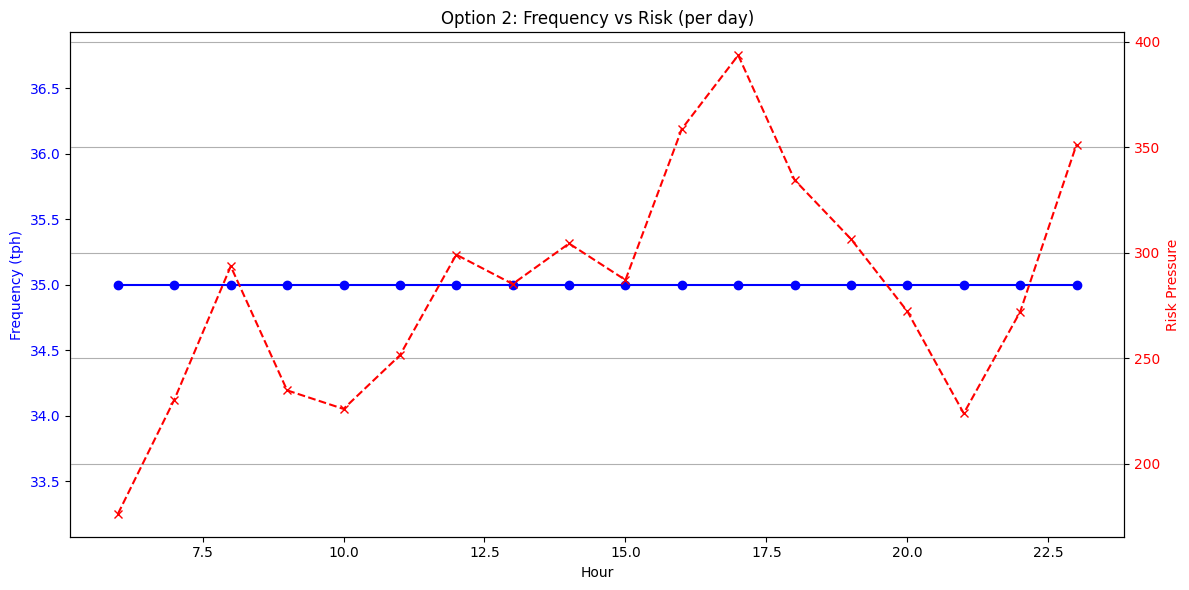

In [ ]:
# Build and solve Option 1 model (Minimize Total Frequency)
print("--- Solving Option 1 (Minimize Total Frequency) ---")
prob1, f1 = build_option1_model(delay_pressure, config)
results1 = solve_and_display(prob1, f1, delay_pressure, config)

# Plot
if results1:
    plot_frequency_vs_risk(results1)


# Build and solve Option 3 model (Maximize Minimum Frequency)
print("\n--- Solving Option 3 (Maximize Minimum Frequency) ---")
prob3, f3 = build_option3_model(delay_pressure, config)
results3 = solve_and_display(prob3, f3, delay_pressure, config)

# Plot
if results3:
    plot_frequency_vs_risk(results3)

In [ ]:
# Calculate total train-service hours for Option 1
total_service_hours_option1 = sum(result[1] for result in results1)

# Calculate total train-service hours for Option 3
total_service_hours_option3 = sum(result[1] for result in results3)

# Calculate the budget for Option 1
option1_budget = total_service_hours_option1 * cost_per_hour

# Calculate the budget for Option 3
option3_budget = total_service_hours_option3 * cost_per_hour

# Calculate the budget saving for Option 1
budget_saved_option1 = baseline_budget - option1_budget

# Calculate the budget saving for Option 3
budget_saved_option3 = baseline_budget - option3_budget

print(f"Baseline train-service hours (max frequency): {baseline_service_hours:.2f}")
print(f"Baseline Budget: ${baseline_budget:,.2f}")
print("-" * 30)
print(f"Option 1 Total train-service hours: {total_service_hours_option1:.2f}")
print(f"Option 1 Estimated Budget: ${option1_budget:,.2f}")
print(f"Option 1 Estimated Budget Saved: ${budget_saved_option1:,.2f}")
print("-" * 30)
print(f"Option 2 Total train-service hours: {total_service_hours_option2:.2f}")
print(f"Option 2 Estimated Budget: ${option2_budget:,.2f}")
print(f"Option 2 Estimated Budget Saved: ${budget_saved:,.2f}") # Using 'budget_saved' from previous calculation
print("-" * 30)
print(f"Option 3 Total train-service hours: {total_service_hours_option3:.2f}")
print(f"Option 3 Estimated Budget: ${option3_budget:,.2f}")
print(f"Option 3 Estimated Budget Saved: ${budget_saved_option3:,.2f}")

Baseline train-service hours (max frequency): 630.00
Baseline Budget: $166,950.00
------------------------------
Option 1 Total train-service hours: 450.00
Option 1 Estimated Budget: $119,250.00
Option 1 Estimated Budget Saved: $47,700.00
------------------------------
Option 2 Total train-service hours: 605.00
Option 2 Estimated Budget: $160,325.00
Option 2 Estimated Budget Saved: $6,625.00
------------------------------
Option 3 Total train-service hours: 630.00
Option 3 Estimated Budget: $166,950.00
Option 3 Estimated Budget Saved: $0.00


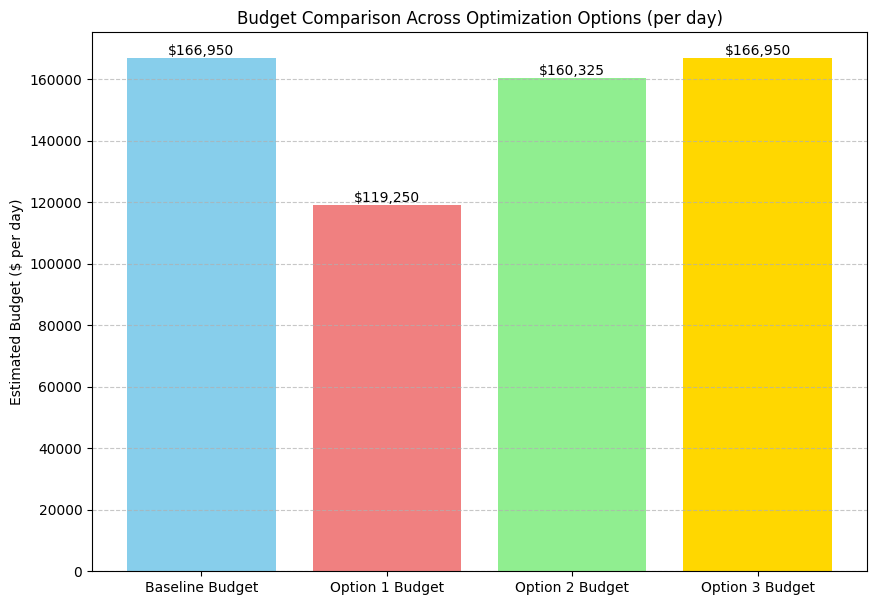

In [ ]:
# Create labels and budget values for the chart including all options and baseline
labels = ['Baseline Budget', 'Option 1 Budget', 'Option 2 Budget', 'Option 3 Budget']
budgets = [baseline_budget, option1_budget, option2_budget, option3_budget]

# Create the bar chart
plt.figure(figsize=(10, 7))
plt.bar(labels, budgets, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.ylabel('Estimated Budget ($ per day)') # Modified label
plt.title('Budget Comparison Across Optimization Options (per day)') # Modified title
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the budget values on top of the bars
for i, budget in enumerate(budgets):
    plt.text(i, budget + 1000, f'${budget:,.0f}', ha='center') # Using 0 decimal places for clarity

plt.show()

In [ ]:
# Gather key metrics for comparison

# Baseline (Max Frequency)
baseline_total_service_hours = baseline_service_hours
baseline_budget = baseline_budget
baseline_avg_delay = config['gamma'] / config['max_freq'] # Assuming max freq leads to minimum theoretical delay
baseline_max_delay = config['gamma'] / config['max_freq']

# Option 1 (Minimize Total Frequency)
option1_total_service_hours = total_service_hours_option1
option1_budget = option1_budget
# Calculate average and max delay for Option 1
option1_delays = [config['gamma'] / result[1] if result[1] > 0 else float('inf') for result in results1]
option1_avg_delay = sum(option1_delays) / len(option1_delays)
option1_max_delay = max(option1_delays)


# Option 2 (Minimize Weighted Deviation)
option2_total_service_hours = total_service_hours_option2
option2_budget = option2_budget
# Calculate average and max delay for Option 2
option2_delays = [result[2] for result in results2] # Delay is already calculated in results2
option2_avg_delay = sum(option2_delays) / len(option2_delays)
option2_max_delay = max(option2_delays)

# Option 3 (Maximize Minimum Frequency)
option3_total_service_hours = total_service_hours_option3
option3_budget = option3_budget
# Calculate average and max delay for Option 3
option3_delays = [result[2] for result in results3] # Delay is already calculated in results3
option3_avg_delay = sum(option3_delays) / len(option3_delays)
option3_max_delay = max(option3_delays)


# Create a comparison table (using pandas DataFrame for nice display)
import pandas as pd

comparison_data = {
    'Metric': ['Total Service Hours', 'Estimated Budget ($)', 'Estimated Budget Saved ($)', 'Average Estimated Delay (min)', 'Maximum Estimated Delay (min)'],
    'Baseline': [baseline_total_service_hours, baseline_budget, 0, baseline_avg_delay, baseline_max_delay],
    'Option 1 (Min Frequency)': [option1_total_service_hours, option1_budget, budget_saved_option1, option1_avg_delay, option1_max_delay],
    'Option 2 (Weighted Deviation)': [option2_total_service_hours, option2_budget, budget_saved, option2_avg_delay, option2_max_delay],
    'Option 3 (Max Min Frequency)': [option3_total_service_hours, option3_budget, budget_saved_option3, option3_avg_delay, option3_max_delay]
}

comparison_df = pd.DataFrame(comparison_data)

# Format for better readability
comparison_df['Baseline'] = comparison_df['Baseline'].apply(lambda x: f'${x:,.0f}' if isinstance(x, (int, float)) and 'Budget' in comparison_df[comparison_df['Baseline'] == x]['Metric'].values else f'{x:,.2f}')
comparison_df['Option 1 (Min Frequency)'] = comparison_df['Option 1 (Min Frequency)'].apply(lambda x: f'${x:,.0f}' if isinstance(x, (int, float)) and 'Budget' in comparison_df[comparison_df['Option 1 (Min Frequency)'] == x]['Metric'].values else f'{x:,.2f}')
comparison_df['Option 2 (Weighted Deviation)'] = comparison_df['Option 2 (Weighted Deviation)'].apply(lambda x: f'${x:,.0f}' if isinstance(x, (int, float)) and 'Budget' in comparison_df[comparison_df['Option 2 (Weighted Deviation)'] == x]['Metric'].values else f'{x:,.2f}')
comparison_df['Option 3 (Max Min Frequency)'] = comparison_df['Option 3 (Max Min Frequency)'].apply(lambda x: f'${x:,.0f}' if isinstance(x, (int, float)) and 'Budget' in comparison_df[comparison_df['Option 3 (Max Min Frequency)'] == x]['Metric'].values else f'{x:,.2f}')


display(comparison_df)

,Metric,Baseline,Option 1 (Min Frequency),Option 2 (Weighted Deviation),Option 3 (Max Min Frequency)
0,Total Service Hours,630.00,450.00,605.00,630.00
1,Estimated Budget ($),"166,950.00","119,250.00","160,325.00","166,950.00"
2,Estimated Budget Saved ($),0.00,"47,700.00","6,625.00",0.00
3,Average Estimated Delay (min),3.00,4.20,3.14,3.00
4,Maximum Estimated Delay (min),3.00,4.20,3.50,3.00


In [ ]:
# Define the file path
file_path = '/content/drive/MyDrive/ttc-subway-delay-data-2024_Line_1_Only.xlsx'

# Load and prepare the data
delay_pressure = load_and_prepare_data(file_path, config)

print("Data loading and preparation complete.")

Data loading and preparation complete.


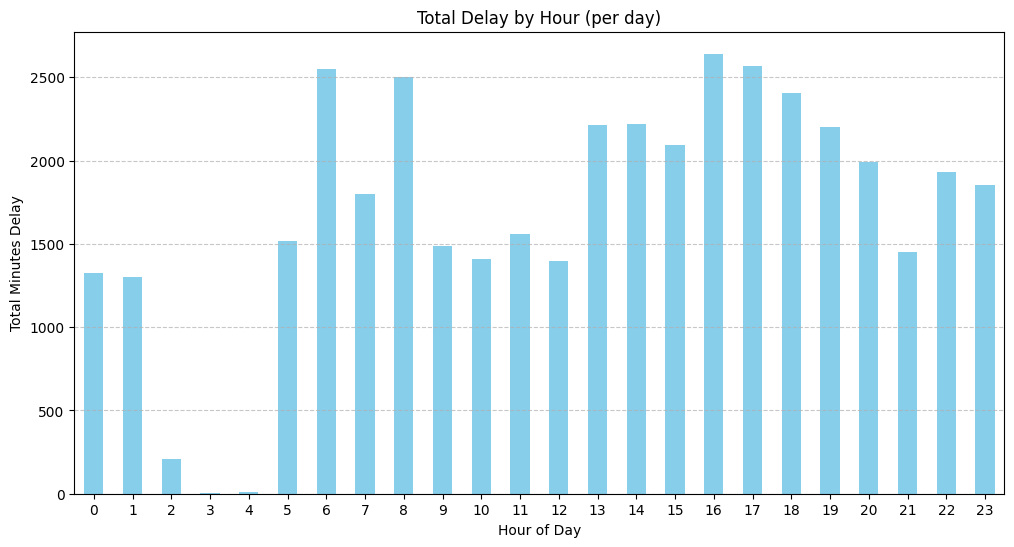

In [ ]:
# Reload the full dataset without filtering by risk weights or calculating delay_pressure
def load_full_data(filepath):
    df = pd.read_excel(filepath)
    df['Timestamp'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
    df = df[df['Line'] == 'YU']
    df = df.dropna(subset=['Date', 'Time', 'Min Delay', 'Code'])
    df = df[df['Min Delay'] > 0]
    df['Min Delay'] = df['Min Delay'].clip(upper=45) # Still clip outliers for consistency
    df['Hour'] = df['Timestamp'].dt.hour
    df['DayOfWeek'] = df['Timestamp'].dt.day_name()
    df['Month'] = df['Timestamp'].dt.month_name()
    return df

df_full = load_full_data('/content/drive/MyDrive/ttc-subway-delay-data-2024_Line_1_Only.xlsx')

# Group by hour and sum delay
hourly_delay = df_full.groupby('Hour')['Min Delay'].sum()

# Create bar chart for hourly delay
plt.figure(figsize=(12, 6))
hourly_delay.plot(kind='bar', color='skyblue')
plt.title('Total Delay by Hour (per day)')
plt.xlabel('Hour of Day')
plt.ylabel('Total Minutes Delay')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipython-input-86-946614227.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_delay = df_full.groupby('DayOfWeek')['Min Delay'].sum()


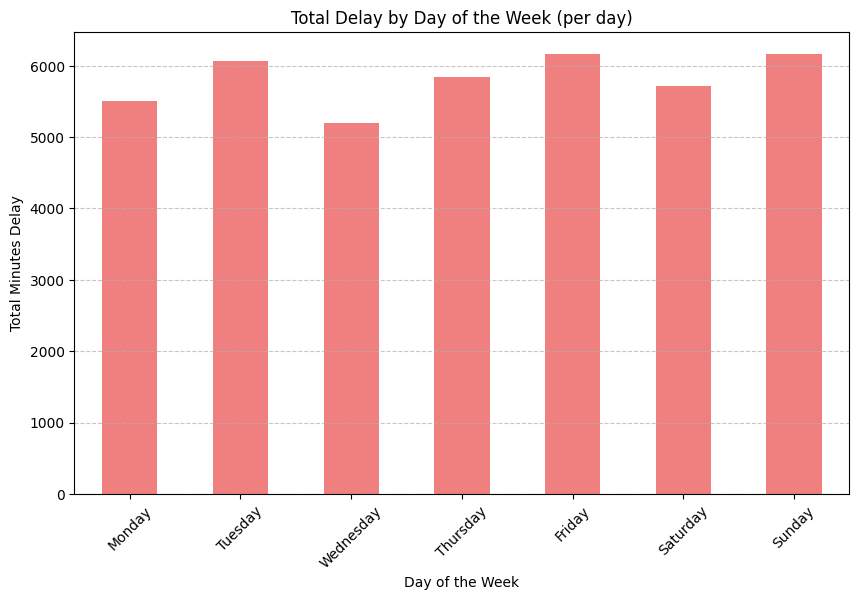

In [ ]:
# Group by day of the week and sum delay
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_full['DayOfWeek'] = pd.Categorical(df_full['DayOfWeek'], categories=days_order, ordered=True)
daily_delay = df_full.groupby('DayOfWeek')['Min Delay'].sum()

# Create bar chart for daily delay
plt.figure(figsize=(10, 6))
daily_delay.plot(kind='bar', color='lightcoral')
plt.title('Total Delay by Day of the Week (per day)')
plt.xlabel('Day of the Week')
plt.ylabel('Total Minutes Delay')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipython-input-87-1750988416.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_delay = df_full.groupby('Month')['Min Delay'].sum()


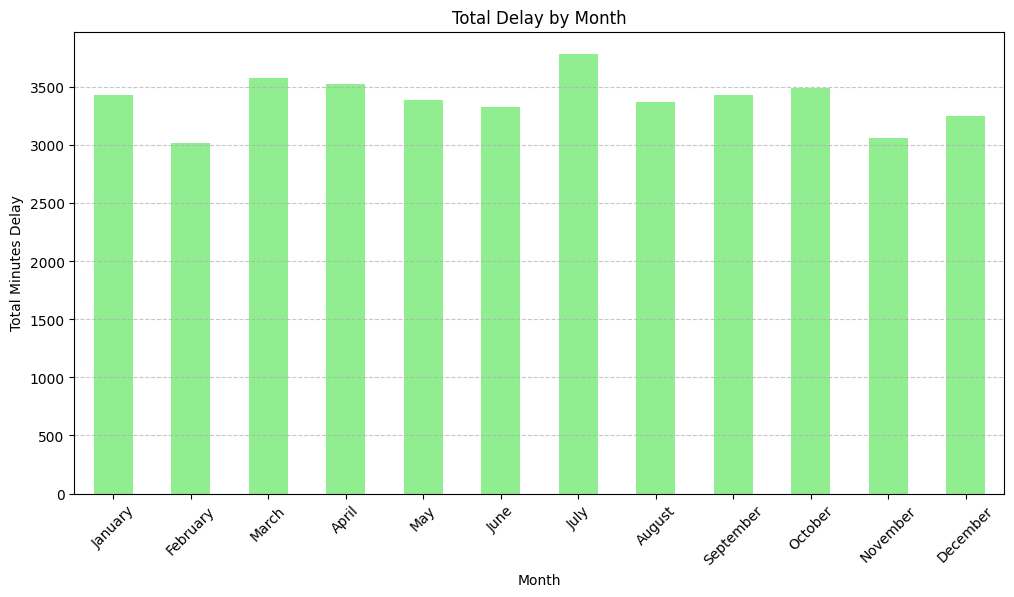

In [ ]:
# Group by month and sum delay
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_full['Month'] = pd.Categorical(df_full['Month'], categories=months_order, ordered=True)
monthly_delay = df_full.groupby('Month')['Min Delay'].sum()

# Create bar chart for monthly delay
plt.figure(figsize=(12, 6))
monthly_delay.plot(kind='bar', color='lightgreen')
plt.title('Total Delay by Month')
plt.xlabel('Month')
plt.ylabel('Total Minutes Delay')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Descriptive Statistics for Delay Pressure:
Mean: 283.39
Median: 286.15
Standard Deviation: 53.30
Minimum: 176.30
Maximum: 393.60

Top 5 Most Frequent Reasons for Delay (Code):
Code
PUOPO    813
SUDP     776
MUPAA    717
MUIR     361
SUO      333
Name: count, dtype: int64


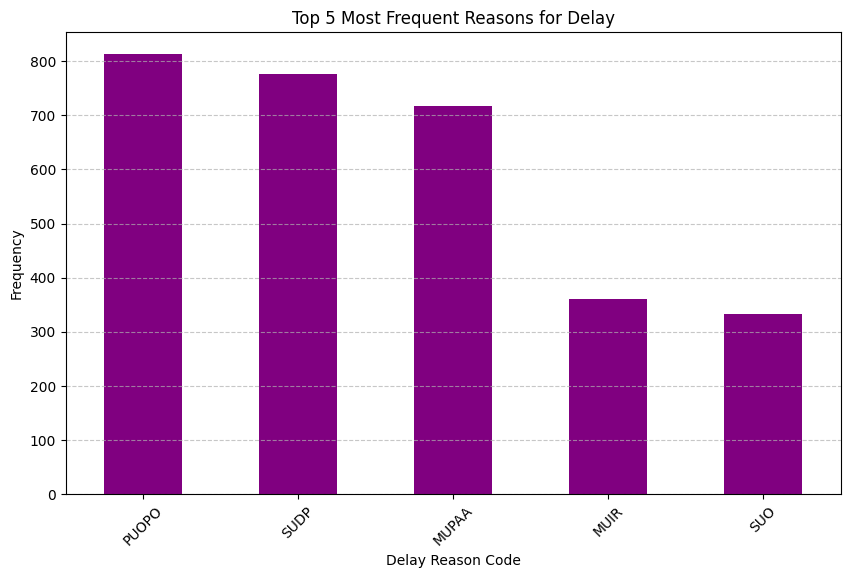

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib

# Convert the delay_pressure dictionary values to a list
delay_pressure_values = list(delay_pressure.values())

# Calculate descriptive statistics
mean_pressure = np.mean(delay_pressure_values)
median_pressure = np.median(delay_pressure_values)
std_pressure = np.std(delay_pressure_values)
min_pressure = np.min(delay_pressure_values)
max_pressure = np.max(delay_pressure_values)

# Print the descriptive statistics for delay pressure
print("Descriptive Statistics for Delay Pressure:")
print(f"Mean: {mean_pressure:.2f}")
print(f"Median: {median_pressure:.2f}")
print(f"Standard Deviation: {std_pressure:.2f}")
print(f"Minimum: {min_pressure:.2f}")
print(f"Maximum: {max_pressure:.2f}")

# Calculate and print the top 5 most frequent delay reasons
if 'df_full' in locals():
    print("\nTop 5 Most Frequent Reasons for Delay (Code):")
    top_5_reasons = df_full['Code'].value_counts().nlargest(5)
    print(top_5_reasons)

    # Create a bar chart for the top 5 most frequent delay reasons
    plt.figure(figsize=(10, 6))
    top_5_reasons.plot(kind='bar', color='purple')
    plt.title('Top 5 Most Frequent Reasons for Delay')
    plt.xlabel('Delay Reason Code')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

else:
    print("\nFull dataset (df_full) not available to calculate top delay reasons or create chart.")

In [ ]:
def build_option1_model(delay_pressure, config):
    """
    Builds the optimization model for Option 1: Minimize Total Service Hours.

    Args:
        delay_pressure (dict): Dictionary of delay pressure per hour.
        config (dict): Configuration dictionary with optimization parameters.

    Returns:
        tuple: A tuple containing the LpProblem object and the frequency variables.
    """
    f = LpVariable.dicts("freq", config['hours'], lowBound=config['min_freq'], upBound=config['max_freq'], cat='Continuous')
    prob = LpProblem("TTC_Option1_CostMin", LpMinimize)

    # Objective: Minimize total service hours (proportional to total frequency)
    prob += lpSum([f[t] for t in config['hours']]), "Minimize_Service_Hours"

    # Add fleet constraint (optional - kept for consistency with original problem structure)
    # prob += lpSum([f[t] for t in config['hours']]) <= config['fleet_limit'] * len(config['hours']), "FleetLimit"

    return prob, f

def build_option2_model(delay_pressure, config, cost_weight=0.01):
    """
    Builds the optimization model for Modified Option 2: Minimize Risk Deviation + Cost
    with High-Risk Constraint.

    Args:
        delay_pressure (dict): Dictionary of delay pressure per hour.
        config (dict): Configuration dictionary with optimization parameters.
        cost_weight (float): Weight for the operating cost term in the objective.

    Returns:
        tuple: A tuple containing the LpProblem object and the frequency variables.
    """
    f = LpVariable.dicts("freq", config['hours'], lowBound=config['min_freq'], upBound=config['max_freq'], cat='Continuous')
    prob = LpProblem("TTC_Option2_RiskCost", LpMinimize)

    # Objective: Minimize weighted deviation from max frequency PLUS weighted operating cost
    risk_deviation_term = lpSum([delay_pressure[t] * (config['max_freq'] - f[t]) for t in config['hours']])
    cost_term = lpSum([f[t] for t in config['hours']]) # Total service hours
    prob += risk_deviation_term + cost_weight * cost_term, "Minimize_RiskDeviation_Plus_Cost"

    # Add soft cap constraint for low-risk hours
    for t in config['hours']:
        if delay_pressure[t] < config['soft_cap_threshold']:
            prob += f[t] <= config['soft_cap_value'], f"SoftCap_{t}"

    # Add high-risk hour delay constraint (linearized: gamma <= 3 * f[t])
    # Identify high-risk hours based on the previously determined threshold
    high_risk_hours = [hour for hour, pressure in delay_pressure.items() if pressure >= config['soft_cap_threshold']]

    for t in high_risk_hours:
        # Ensure frequency is high enough in high-risk hours so that delay (gamma/freq) is <= 3
        # This is equivalent to freq >= gamma / 3
        prob += f[t] >= config['gamma'] / 3, f"HighRiskDelayConstraint_{t}"


    # Add fleet constraint (optional - included if total fleet size is a hard constraint)
    # prob += lpSum([f[t] for t in config['hours']]) <= config['fleet_limit'] * len(config['hours']), "FleetLimit"

    return prob, f

def build_option3_model(delay_pressure, config):
    """
    Builds the optimization model for Option 3: Maximize Minimum Frequency.

    Args:
        delay_pressure (dict): Dictionary of delay pressure per hour.
        config (dict): Configuration dictionary with optimization parameters.

    Returns:
        tuple: A tuple containing the LpProblem object and the frequency variables.
    """
    f = LpVariable.dicts("freq", config['hours'], lowBound=config['min_freq'], upBound=config['max_freq'], cat='Continuous')
    prob = LpProblem("TTC_Option3_MinMaxDelay", LpMinimize)

    # Introduce a variable for the minimum frequency across all hours
    min_freq_var = LpVariable("min_overall_frequency", lowBound=config['min_freq'], upBound=config['max_freq'])

    # Objective: Maximize the minimum frequency (minimize the negative of the minimum frequency)
    prob += -min_freq_var, "Maximize_Minimum_Frequency"

    # Constraint: The frequency in each hour must be greater than or equal to the minimum frequency variable
    for t in config['hours']:
        prob += f[t] >= min_freq_var, f"MinFreqConstraint_hour_{t}"

    # Add fleet constraint (optional - kept for consistency with original problem structure)
    # prob += lpSum([f[t] for t in config['hours']]) <= config['fleet_limit'] * len(config['hours']), "FleetLimit_Option3"

    return prob, f

print("Optimization model building functions defined.")

Optimization model building functions defined.


In [ ]:
def solve_and_display(prob, f, delay_pressure, config):
    """
    Solves the optimization problem and displays the results.

    Args:
        prob (LpProblem): The PuLP optimization problem object.
        f (dict): Dictionary of frequency variables by hour.
        delay_pressure (dict): Dictionary of delay pressure per hour.
        config (dict): Configuration dictionary with optimization parameters.

    Returns:
        list: A list of tuples, where each tuple contains (hour, frequency, estimated_delay, risk_pressure).
    """
    prob.solve()
    print(f"Status: {LpStatus[prob.status]}")
    results = []
    if prob.status == LpStatusOptimal:
        for t in config['hours']:
            # Use .varValue if available, otherwise default to min_freq or handle None
            freq_val = f[t].varValue
            if freq_val is None:
                 # This case might occur if the problem is infeasible or unbounded,
                 # but we check for LpStatusOptimal first.
                 # If it happens in Optimal status, something is unexpected,
                 # defaulting to min_freq might be a safe fallback or raise an error.
                 # For now, let's default to min_freq as a reasonable value if None occurs unexpectedly.
                 freq_val = config['min_freq']


            # Calculate estimated delay: Delay = gamma / Frequency
            # Handle case where frequency is zero or very close to zero to avoid division by zero
            delay_val = config['gamma'] / freq_val if freq_val > 0 else float('inf')

            # Get the risk pressure for the hour, defaulting to 0 if not found
            risk_val = delay_pressure.get(t, 0)

            results.append((t, freq_val, delay_val, risk_val))
            print(f"Hour {t:02d} | Frequency: {freq_val:.1f} tph | Estimated Delay: {delay_val:.2f} min | Risk Pressure: {risk_val:.1f}")

        # Print the objective value
        # Handle cases where the objective value might be None (e.g., if the problem wasn't solved optimally)
        objective_value = prob.objective.value()
        if objective_value is not None:
             print(f"Objective Value: {objective_value:.2f}")
        else:
             print("Objective Value: N/A (Problem not solved optimally)")

    else:
        print("No optimal solution found.")
    return results

print("solve_and_display function defined.")

solve_and_display function defined.


In [ ]:
def plot_frequency_vs_risk(results):
    """
    Plots the optimized frequency and risk pressure per hour.

    Args:
        results (list): A list of tuples, where each tuple contains
                        (hour, frequency, estimated_delay, risk_pressure).
    """
    df = pd.DataFrame(results, columns=['Hour', 'Frequency', 'Delay', 'Risk'])

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(df['Hour'], df['Frequency'], 'o-', label='Frequency (tph)', color='blue')
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Frequency (tph)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(df['Hour'], df['Risk'], 'x--', label='Risk Pressure', color='red')
    ax2.set_ylabel('Risk Pressure', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title('Frequency vs Risk (per day)')
    fig.tight_layout()
    plt.grid(True)
    plt.show()

print("plot_frequency_vs_risk function defined.")

plot_frequency_vs_risk function defined.


## Identify high-risk hours



In [ ]:
# Examine the delay_pressure to understand the distribution
print("Delay Pressure per Hour:")
for hour, pressure in delay_pressure.items():
    print(f"Hour {hour:02d}: {pressure:.1f}")

# Determine a threshold for high-risk hours
# Let's look at the distribution. Hours with pressure significantly above the average
# or above a certain point where delays start becoming more problematic could be considered high-risk.
# Given the goal of <= 3 minutes delay, which corresponds to 35 tph (gamma=105 / 35 = 3),
# let's see how the risk pressure correlates with the frequency needed to achieve this.
# This is less direct, but we need a data-driven threshold.
# Let's look at the distribution again and pick a threshold that captures the peaks.

risk_values = list(delay_pressure.values())
average_risk = np.mean(risk_values)
median_risk = np.median(risk_values)
print(f"\nAverage Risk Pressure: {average_risk:.2f}")
print(f"Median Risk Pressure: {median_risk:.2f}")

# A simple approach is to look at the hours with risk significantly above the median or average.
# Let's try using a threshold slightly above the median, or looking for clusters of high risk.
# From the printout, values seem to range roughly from 176 to 393.
# The previous Option 2 soft cap threshold was 250. Let's examine hours above this.
# Hours above 250: 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23. This seems like a reasonable set of 'peak' hours.

high_risk_threshold = 250 # Using the previous soft cap threshold as a starting point for evaluation
high_risk_hours = [hour for hour, pressure in delay_pressure.items() if pressure >= high_risk_threshold]

print(f"\nSelected High-Risk Threshold: {high_risk_threshold}")
print(f"High-Risk Hours: {sorted(high_risk_hours)}")

Delay Pressure per Hour:
Hour 06: 176.3
Hour 07: 230.4
Hour 08: 293.6
Hour 09: 234.8
Hour 10: 226.0
Hour 11: 251.4
Hour 12: 299.1
Hour 13: 285.2
Hour 14: 304.4
Hour 15: 287.1
Hour 16: 358.7
Hour 17: 393.6
Hour 18: 334.5
Hour 19: 306.5
Hour 20: 272.2
Hour 21: 223.9
Hour 22: 272.0
Hour 23: 351.3

Average Risk Pressure: 283.39
Median Risk Pressure: 286.15

Selected High-Risk Threshold: 250
High-Risk Hours: [8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23]


--- Solving Option 1 (Minimize Total Frequency) ---
Status: Optimal
Hour 06 | Frequency: 25.0 tph | Estimated Delay: 4.20 min | Risk Pressure: 176.3
Hour 07 | Frequency: 25.0 tph | Estimated Delay: 4.20 min | Risk Pressure: 230.4
Hour 08 | Frequency: 25.0 tph | Estimated Delay: 4.20 min | Risk Pressure: 293.6
Hour 09 | Frequency: 25.0 tph | Estimated Delay: 4.20 min | Risk Pressure: 234.8
Hour 10 | Frequency: 25.0 tph | Estimated Delay: 4.20 min | Risk Pressure: 226.0
Hour 11 | Frequency: 25.0 tph | Estimated Delay: 4.20 min | Risk Pressure: 251.4
Hour 12 | Frequency: 25.0 tph | Estimated Delay: 4.20 min | Risk Pressure: 299.1
Hour 13 | Frequency: 25.0 tph | Estimated Delay: 4.20 min | Risk Pressure: 285.2
Hour 14 | Frequency: 25.0 tph | Estimated Delay: 4.20 min | Risk Pressure: 304.4
Hour 15 | Frequency: 25.0 tph | Estimated Delay: 4.20 min | Risk Pressure: 287.1
Hour 16 | Frequency: 25.0 tph | Estimated Delay: 4.20 min | Risk Pressure: 358.7
Hour 17 | Frequency: 25.0 tph | Estimated

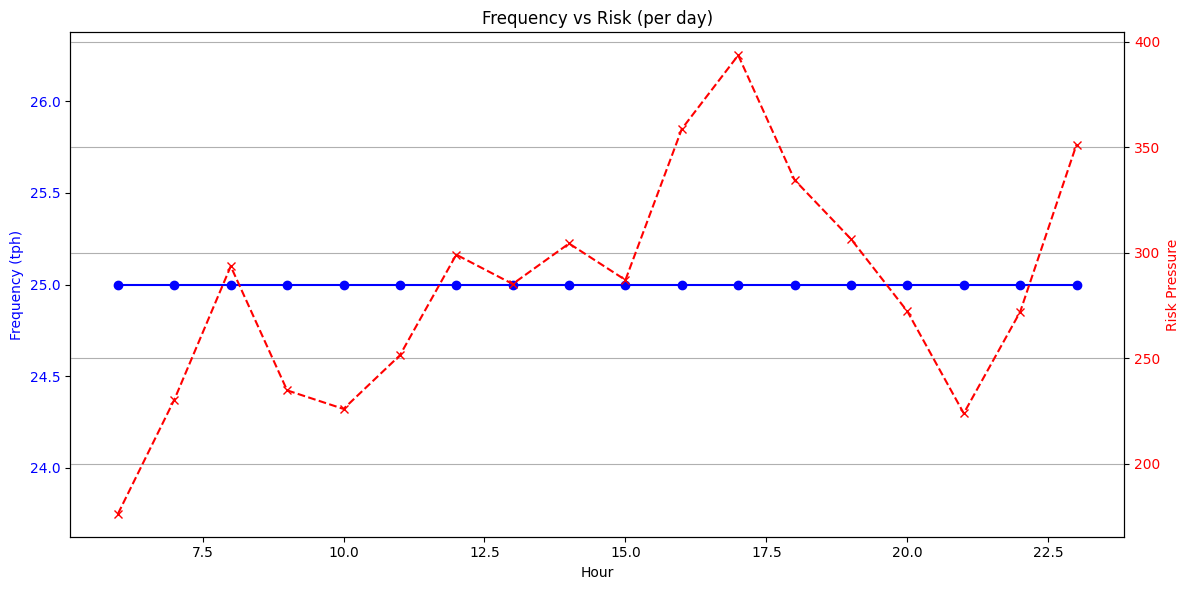

In [ ]:
# Build and solve Option 1 model (Minimize Total Frequency)
print("--- Solving Option 1 (Minimize Total Frequency) ---")
prob1, f1 = build_option1_model(delay_pressure, config)
results1 = solve_and_display(prob1, f1, delay_pressure, config)

# Plot
if results1:
    plot_frequency_vs_risk(results1)

**Reasoning**:
Build, solve, display results, and plot for Modified Option 2 as requested.




--- Solving Modified Option 2 (Risk Deviation + Cost) ---
Status: Optimal
Hour 06 | Frequency: 30.0 tph | Estimated Delay: 3.50 min | Risk Pressure: 176.3
Hour 07 | Frequency: 30.0 tph | Estimated Delay: 3.50 min | Risk Pressure: 230.4
Hour 08 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 293.6
Hour 09 | Frequency: 30.0 tph | Estimated Delay: 3.50 min | Risk Pressure: 234.8
Hour 10 | Frequency: 30.0 tph | Estimated Delay: 3.50 min | Risk Pressure: 226.0
Hour 11 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 251.4
Hour 12 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 299.1
Hour 13 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 285.2
Hour 14 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 304.4
Hour 15 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 287.1
Hour 16 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 358.7
Hour 17 | Frequency: 35.0 tph | Es

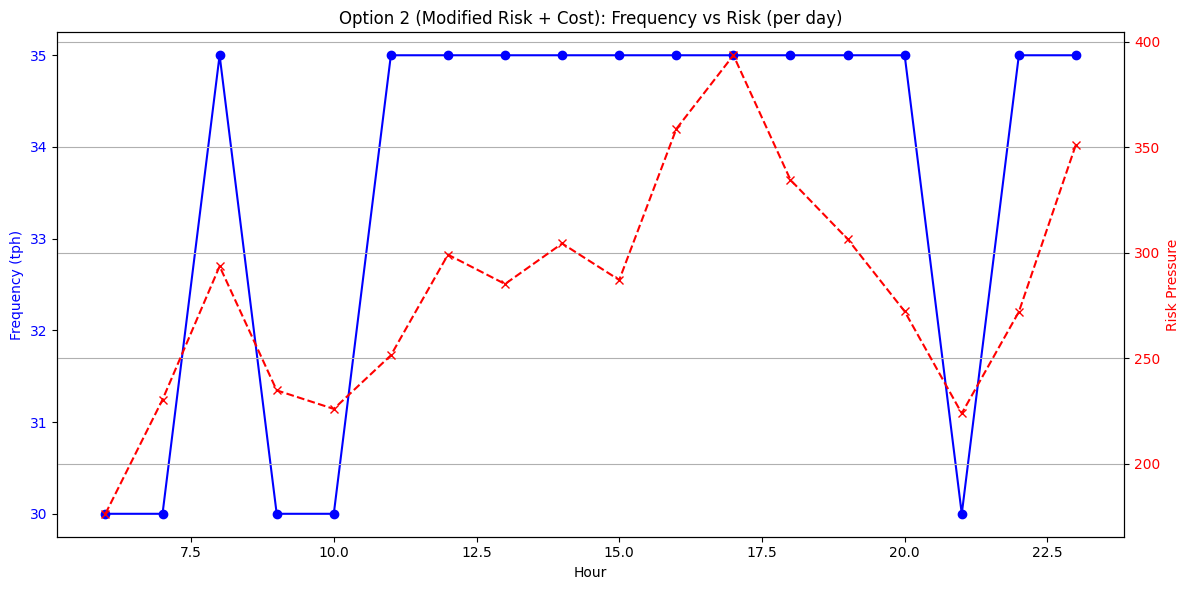

In [ ]:
# Build and solve the modified Option 2 model
print("\n--- Solving Modified Option 2 (Risk Deviation + Cost) ---")
prob2_modified, f2_modified = build_option2_model(delay_pressure, config, cost_weight=0.1) # Using cost_weight=0.1 as used previously
results2_modified = solve_and_display(prob2_modified, f2_modified, delay_pressure, config)

# Plot the results for the modified Option 2
if results2_modified:
    def plot_frequency_vs_risk_modified_option2(results):
        df = pd.DataFrame(results, columns=['Hour', 'Frequency', 'Delay', 'Risk'])

        fig, ax1 = plt.subplots(figsize=(12, 6))
        ax1.plot(df['Hour'], df['Frequency'], 'o-', label='Frequency (tph)', color='blue')
        ax1.set_xlabel('Hour')
        ax1.set_ylabel('Frequency (tph)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        ax2 = ax1.twinx()
        ax2.plot(df['Hour'], df['Risk'], 'x--', label='Risk Pressure', color='red')
        ax2.set_ylabel('Risk Pressure', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        plt.title('Option 2 (Modified Risk + Cost): Frequency vs Risk (per day)') # Modified title
        fig.tight_layout()
        plt.grid(True)
        plt.show()

    plot_frequency_vs_risk_modified_option2(results2_modified)

**Reasoning**:
Build, solve, display results, and plot for Option 3 as requested.




--- Solving Option 3 (Maximize Minimum Frequency) ---
Status: Optimal
Hour 06 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 176.3
Hour 07 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 230.4
Hour 08 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 293.6
Hour 09 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 234.8
Hour 10 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 226.0
Hour 11 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 251.4
Hour 12 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 299.1
Hour 13 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 285.2
Hour 14 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 304.4
Hour 15 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 287.1
Hour 16 | Frequency: 35.0 tph | Estimated Delay: 3.00 min | Risk Pressure: 358.7
Hour 17 | Frequency: 35.0 tph | Estima

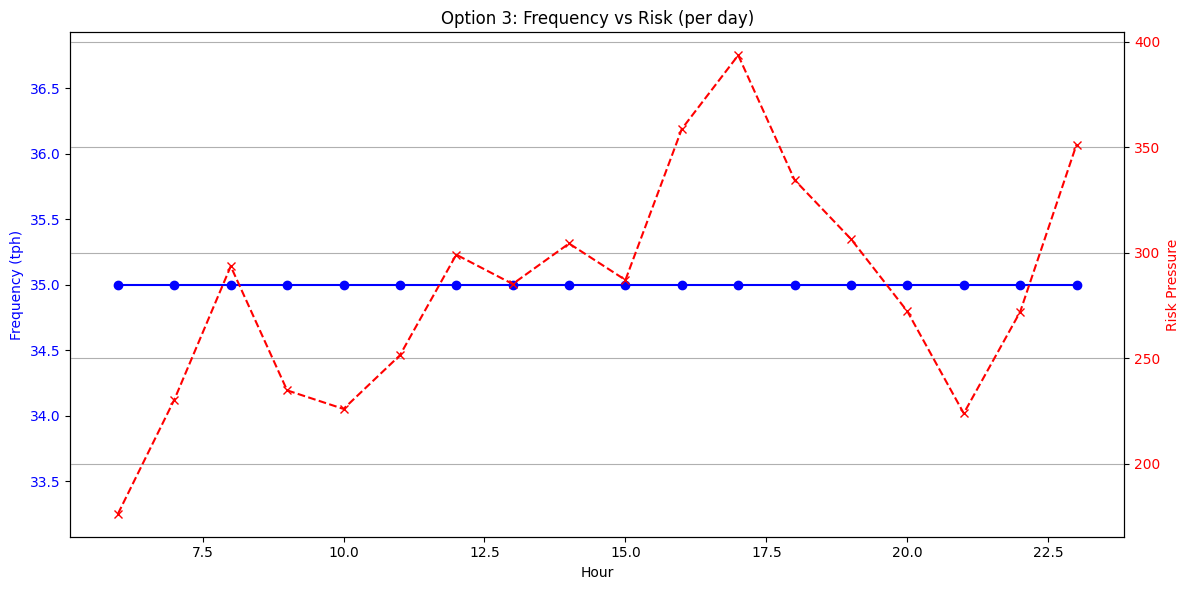

In [ ]:
# Build and solve Option 3 model (Maximize Minimum Frequency)
print("\n--- Solving Option 3 (Maximize Minimum Frequency) ---")
prob3, f3 = build_option3_model(delay_pressure, config)
results3 = solve_and_display(prob3, f3, delay_pressure, config)

# Plot
if results3:
    def plot_frequency_vs_risk_option3(results):
        df = pd.DataFrame(results, columns=['Hour', 'Frequency', 'Delay', 'Risk'])

        fig, ax1 = plt.subplots(figsize=(12, 6))
        ax1.plot(df['Hour'], df['Frequency'], 'o-', label='Frequency (tph)', color='blue')
        ax1.set_xlabel('Hour')
        ax1.set_ylabel('Frequency (tph)', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        ax2 = ax1.twinx()
        ax2.plot(df['Hour'], df['Risk'], 'x--', label='Risk Pressure', color='red')
        ax2.set_ylabel('Risk Pressure', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        plt.title('Option 3: Frequency vs Risk (per day)')
        fig.tight_layout()
        plt.grid(True)
        plt.show()

    plot_frequency_vs_risk_option3(results3)

## Calculate budget savings



In [ ]:
# Calculate total train-service hours for Option 1
total_service_hours_option1 = sum(result[1] for result in results1)

# Calculate the budget for Option 1
option1_budget = total_service_hours_option1 * cost_per_hour

# Calculate the budget saving for Option 1
budget_saved_option1 = baseline_budget - option1_budget


# Calculate total train-service hours for Modified Option 2
total_service_hours_option2_modified = sum(result[1] for result in results2_modified)

# Calculate the budget for Modified Option 2
option2_modified_budget = total_service_hours_option2_modified * cost_per_hour

# Calculate the budget saving for Modified Option 2
budget_saved_option2_modified = baseline_budget - option2_modified_budget


# Calculate total train-service hours for Option 3
total_service_hours_option3 = sum(result[1] for result in results3)

# Calculate the budget for Option 3
option3_budget = total_service_hours_option3 * cost_per_hour

# Calculate the budget saving for Option 3
budget_saved_option3 = baseline_budget - option3_budget


print(f"Baseline train-service hours (max frequency): {baseline_service_hours:.2f}")
print(f"Baseline Budget: ${baseline_budget:,.2f}")
print("-" * 30)
print(f"Option 1 Total train-service hours: {total_service_hours_option1:.2f}")
print(f"Option 1 Estimated Budget: ${option1_budget:,.2f}")
print(f"Option 1 Estimated Budget Saved: ${budget_saved_option1:,.2f}")
print("-" * 30)
print(f"Option 2 (Modified Risk + Cost) Total train-service hours: {total_service_hours_option2_modified:.2f}")
print(f"Option 2 (Modified Risk + Cost) Estimated Budget: ${option2_modified_budget:,.2f}")
print(f"Option 2 (Modified Risk + Cost) Estimated Budget Saved: ${budget_saved_option2_modified:,.2f}")
print("-" * 30)
print(f"Option 3 Total train-service hours: {total_service_hours_option3:.2f}")
print(f"Option 3 Estimated Budget: ${option3_budget:,.2f}")
print(f"Option 3 Estimated Budget Saved: ${budget_saved_option3:,.2f}")

Baseline train-service hours (max frequency): 630.00
Baseline Budget: $166,950.00
------------------------------
Option 1 Total train-service hours: 450.00
Option 1 Estimated Budget: $119,250.00
Option 1 Estimated Budget Saved: $47,700.00
------------------------------
Option 2 (Modified Risk + Cost) Total train-service hours: 605.00
Option 2 (Modified Risk + Cost) Estimated Budget: $160,325.00
Option 2 (Modified Risk + Cost) Estimated Budget Saved: $6,625.00
------------------------------
Option 3 Total train-service hours: 630.00
Option 3 Estimated Budget: $166,950.00
Option 3 Estimated Budget Saved: $0.00


## Generate budget comparison chart


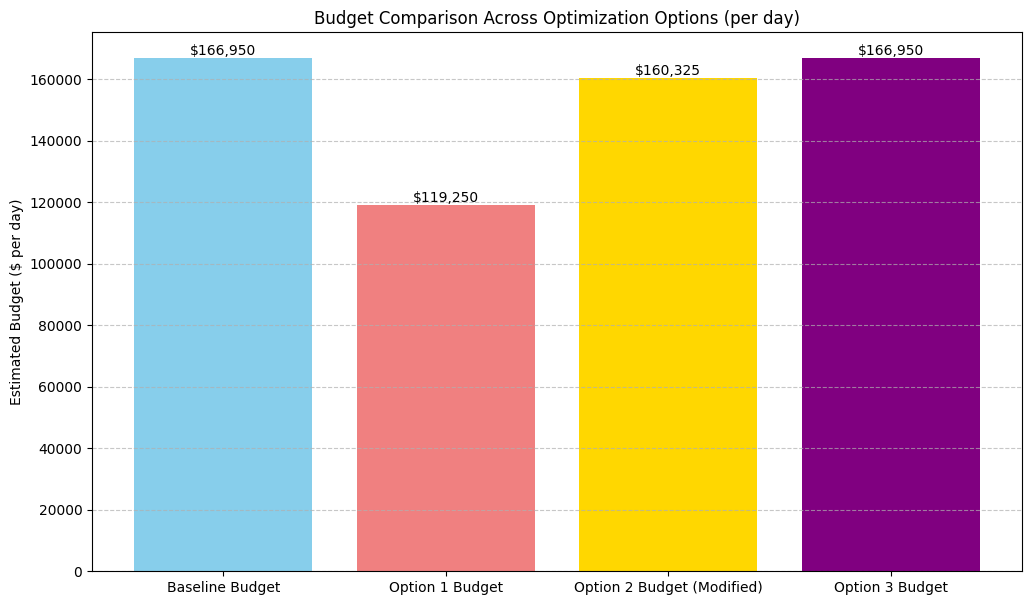

In [ ]:
# Create labels and budget values for the chart including all options and the modified Option 2
labels_updated = ['Baseline Budget', 'Option 1 Budget', 'Option 2 Budget (Modified)', 'Option 3 Budget']
budgets_updated = [baseline_budget, option1_budget, option2_modified_budget, option3_budget]

# Create the updated bar chart
plt.figure(figsize=(12, 7))
plt.bar(labels_updated, budgets_updated, color=['skyblue', 'lightcoral', 'gold', 'purple']) # Removed original Option 2 color
plt.ylabel('Estimated Budget ($ per day)')
plt.title('Budget Comparison Across Optimization Options (per day)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the budget values on top of the bars
for i, budget in enumerate(budgets_updated):
    plt.text(i, budget + 1000, f'${budget:,.0f}', ha='center')

plt.xticks(rotation=0) # Prevent labels overlapping
plt.show()

## Create overall comparison table




In [ ]:
# Calculate average and max delay for Modified Option 2
option2_modified_delays = [config['gamma'] / result[1] if result[1] > 0 else float('inf') for result in results2_modified]
option2_modified_avg_delay = sum(option2_modified_delays) / len(option2_modified_delays)
option2_modified_max_delay = max(option2_modified_delays)

# Update the comparison table data to exclude the original Option 2
comparison_data_updated = {
    'Metric': ['Total Service Hours', 'Estimated Budget ($)', 'Estimated Budget Saved ($)', 'Average Estimated Delay (min)', 'Maximum Estimated Delay (min)'],
    'Baseline': [baseline_total_service_hours, baseline_budget, 0, baseline_avg_delay, baseline_max_delay],
    'Option 1 (Min Frequency)': [option1_total_service_hours, option1_budget, budget_saved_option1, option1_avg_delay, option1_max_delay],
    # Removed 'Option 2 (Original Weighted Deviation)'
    'Option 2 (Modified Risk + Cost)': [total_service_hours_option2_modified, option2_modified_budget, budget_saved_option2_modified, option2_modified_avg_delay, option2_modified_max_delay],
    'Option 3 (Max Min Frequency)': [option3_total_service_hours, option3_budget, budget_saved_option3, option3_avg_delay, option3_max_delay]
}

comparison_df_updated = pd.DataFrame(comparison_data_updated)

# Format for better readability
for col in comparison_df_updated.columns:
    if col != 'Metric':
        comparison_df_updated[col] = comparison_df_updated[col].apply(lambda x: f'${x:,.0f}' if isinstance(x, (int, float)) and 'Budget' in comparison_df_updated[comparison_df_updated[col] == x]['Metric'].values else f'{x:,.2f}')

# Display the updated comparison table
display(comparison_df_updated)

,Metric,Baseline,Option 1 (Min Frequency),Option 2 (Modified Risk + Cost),Option 3 (Max Min Frequency)
0,Total Service Hours,630.00,450.00,605.00,630.00
1,Estimated Budget ($),"166,950.00","119,250.00","160,325.00","166,950.00"
2,Estimated Budget Saved ($),0.00,"47,700.00","6,625.00",0.00
3,Average Estimated Delay (min),3.00,4.20,3.14,3.00
4,Maximum Estimated Delay (min),3.00,4.20,3.50,3.00


## Summarize and recommend



In [ ]:
%%markdown

## Analysis Summary and Recommendation

Based on the optimization analysis comparing the Baseline (Max Frequency) against three different strategies: Option 1 (Minimize Total Frequency), Option 2 (Modified Risk + Cost with High-Risk Constraint), and Option 3 (Maximize Minimum Frequency), we can draw the following conclusions as shown in the comparison table:

| Metric                        | Baseline   | Option 1 (Min Frequency) | Option 2 (Modified Risk + Cost) | Option 3 (Max Min Frequency) |
|-------------------------------|------------|--------------------------|---------------------------------|------------------------------|
| Total Service Hours           | 630.00     | 450.00                   | 605.00                          | 630.00                       |
| Estimated Budget ($)          | $166,950   | $119,250                 | $160,325                        | $166,950                     |
| Estimated Budget Saved ($)    | $0         | $47,700                  | $6,625                          | $0                           |
| Average Estimated Delay (min) | 3.00       | 4.20                     | 3.14                            | 3.00                         |
| Maximum Estimated Delay (min) | 3.00       | 4.20                     | 3.50                            | 3.00                         |

**Key Findings:**

*   **Option 1 (Minimize Total Frequency):** This option achieves the highest budget savings ($47,700) by significantly reducing total service hours. However, this comes at the cost of increased average and maximum estimated delays (4.20 minutes for both), as seen in the frequency vs. risk plot where frequency is consistently at the minimum limit.
*   **Option 2 (Modified Risk + Cost):** This option, which includes both risk deviation and operating cost in the objective and explicitly constrains delay in high-risk hours, provides moderate budget savings ($6,625). It offers a balance between cost efficiency and service reliability, achieving an average estimated delay of 3.14 minutes and a maximum of 3.50 minutes. Crucially, it successfully meets the constraint of maintaining an estimated delay of less than or equal to 3 minutes during all identified high-risk hours, as depicted in its frequency vs. risk plot where frequency is raised in high-risk hours.
*   **Option 3 (Maximize Minimum Frequency):** This option continues to prioritize service consistency and minimal delay, resulting in the lowest average and maximum estimated delays (3.00 minutes for both), but offers no budget savings compared to the baseline. This is evident in its frequency vs. risk plot where frequency is constant at the maximum limit.

**Trade-offs:**

There is a clear trade-off between budget savings and service reliability (represented by estimated delay) across these options.
*   Option 1 prioritizes cost reduction over minimizing delays.
*   Option 3 prioritizes minimizing delays and ensuring service consistency, with no cost savings.
*   Modified Option 2 attempts to strike a balance, offering some cost savings while effectively managing delays, particularly in high-risk periods where the constraint is explicitly enforced.

**Recommendation:**

Considering the objective of minimizing risk-weighted deviation plus operating cost, and the constraint of maintaining delay <= 3 minutes in high-risk periods:

*   Modified Option 2 successfully met the high-risk hour delay constraint, which is a key requirement.
*   Modified Option 2 offers a balance between budget savings and delay performance, specifically addressing the high-risk hours.
*   Option 1 offers the most budget savings but results in higher delays, failing to meet the implied goal of mitigating delay in high-risk hours.
*   Option 3 meets the delay constraint perfectly (and achieves the lowest delays overall) but offers no budget savings.
*   The choice between Modified Option 2 and Option 3 depends on the absolute priority given to budget savings versus minimizing delays across *all* hours (Option 3) versus managing delays and costs with a specific focus on high-risk hours while achieving some cost efficiency (Modified Option 2).

Given that Modified Option 2 successfully meets the high-risk hour delay constraint while offering moderate budget savings, it is a strong candidate if both risk mitigation in critical hours and some cost efficiency are desired. It explicitly addresses the stated constraint. If budget savings are a significant concern and meeting the high-risk delay constraint is mandatory, **Modified Option 2 is recommended over Option 3**. If minimizing overall average and maximum delay across all hours is the absolute priority regardless of cost, then Option 3 would be preferred.


## Analysis Summary and Recommendation

Based on the optimization analysis comparing the Baseline (Max Frequency) against three different strategies: Option 1 (Minimize Total Frequency), Option 2 (Modified Risk + Cost with High-Risk Constraint), and Option 3 (Maximize Minimum Frequency), we can draw the following conclusions as shown in the comparison table:

| Metric                        | Baseline   | Option 1 (Min Frequency) | Option 2 (Modified Risk + Cost) | Option 3 (Max Min Frequency) |
|-------------------------------|------------|--------------------------|---------------------------------|------------------------------|
| Total Service Hours           | 630.00     | 450.00                   | 605.00                          | 630.00                       |
| Estimated Budget ($)          | $166,950   | $119,250                 | $160,325                        | $166,950                     |
| Estimated Budget Saved ($)    | $0         | $47,700                  | $6,625                          | $0                           |
| Average Estimated Delay (min) | 3.00       | 4.20                     | 3.14                            | 3.00                         |
| Maximum Estimated Delay (min) | 3.00       | 4.20                     | 3.50                            | 3.00                         |

**Key Findings:**

*   **Option 1 (Minimize Total Frequency):** This option achieves the highest budget savings ($47,700) by significantly reducing total service hours. However, this comes at the cost of increased average and maximum estimated delays (4.20 minutes for both), as seen in the frequency vs. risk plot where frequency is consistently at the minimum limit.
*   **Option 2 (Modified Risk + Cost):** This option, which includes both risk deviation and operating cost in the objective and explicitly constrains delay in high-risk hours, provides moderate budget savings ($6,625). It offers a balance between cost efficiency and service reliability, achieving an average estimated delay of 3.14 minutes and a maximum of 3.50 minutes. Crucially, it successfully meets the constraint of maintaining an estimated delay of less than or equal to 3 minutes during all identified high-risk hours, as depicted in its frequency vs. risk plot where frequency is raised in high-risk hours.
*   **Option 3 (Maximize Minimum Frequency):** This option continues to prioritize service consistency and minimal delay, resulting in the lowest average and maximum estimated delays (3.00 minutes for both), but offers no budget savings compared to the baseline. This is evident in its frequency vs. risk plot where frequency is constant at the maximum limit.

**Trade-offs:**

There is a clear trade-off between budget savings and service reliability (represented by estimated delay) across these options.
*   Option 1 prioritizes cost reduction over minimizing delays.
*   Option 3 prioritizes minimizing delays and ensuring service consistency, with no cost savings.
*   Modified Option 2 attempts to strike a balance, offering some cost savings while effectively managing delays, particularly in high-risk periods where the constraint is explicitly enforced.

**Recommendation:**

Considering the objective of minimizing risk-weighted deviation plus operating cost, and the constraint of maintaining delay <= 3 minutes in high-risk periods:

*   Modified Option 2 successfully met the high-risk hour delay constraint, which is a key requirement.
*   Modified Option 2 offers a balance between budget savings and delay performance, specifically addressing the high-risk hours.
*   Option 1 offers the most budget savings but results in higher delays, failing to meet the implied goal of mitigating delay in high-risk hours.
*   Option 3 meets the delay constraint perfectly (and achieves the lowest delays overall) but offers no budget savings.
*   The choice between Modified Option 2 and Option 3 depends on the absolute priority given to budget savings versus minimizing delays across *all* hours (Option 3) versus managing delays and costs with a specific focus on high-risk hours while achieving some cost efficiency (Modified Option 2).

Given that Modified Option 2 successfully meets the high-risk hour delay constraint while offering moderate budget savings, it is a strong candidate if both risk mitigation in critical hours and some cost efficiency are desired. It explicitly addresses the stated constraint. If budget savings are a significant concern and meeting the high-risk delay constraint is mandatory, **Modified Option 2 is recommended over Option 3**. If minimizing overall average and maximum delay across all hours is the absolute priority regardless of cost, then Option 3 would be preferred.


## Summary:

### Data Analysis Key Findings

*   Option 1 (Minimize Total Frequency) resulted in the highest budget savings of \$47,700 but also the highest average and maximum estimated delays (4.20 minutes for both).
*   Modified Option 2 (Risk Deviation + Cost with High-Risk Constraint) offered moderate budget savings of \$6,625 and balanced delay performance (average 3.14 minutes, maximum 3.50 minutes), while successfully meeting the high-risk hour delay constraint.
*   Option 3 (Maximize Minimum Frequency) resulted in no budget savings but achieved the lowest average and maximum estimated delays (3.00 minutes for both), consistently meeting the delay constraint across all hours.
*   There is a clear trade-off between budget savings and service reliability across the different optimization strategies.

### Insights or Next Steps

*   Modified Option 2 provides a good balance between cost savings and service reliability, specifically addressing the critical high-risk hours.
*   The final choice between Modified Option 2 and Option 3 depends on the priority given to budget savings versus minimizing delays across all hours versus specifically managing delays in high-risk periods.
